## Redo XGboost

In [94]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt


In [95]:
###############################################################################
# Figure configuration
import matplotlib as mpl
plt.rcParams['figure.figsize'] = (16, 6)

###############################################################################
# Load and Define dataset:
start_date = datetime(2021,1,1)
end_date = datetime(2023,10,31)
DATA_raw = pd.read_csv('META_FeatureMart.csv', index_col = [0])
DATA_raw.describe()

,MKT-RF,SMB,HML,RMW,CMA,RF,ADS_INDEX,SP500,T10Y3M,OBMMIJUMBO30YF,...,USRECDM,USRECDP,META_OPEN,META_HIGH,META_LOW,META_CLOSE,META_ADJ CLOSE,META_VOLUME,META_DAILY_RETURN,META_RSI
count,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1707.000000,1703.000000,...,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1.719000e+03,1718.000000,1706.000000
mean,0.030762,-0.019622,-0.010803,0.019593,0.000518,0.006341,-0.230073,3398.195526,0.590410,4.464628,...,0.023851,0.023851,212.400797,215.242688,209.693514,212.509506,212.509506,2.326401e+07,0.000882,53.841355
std,1.012749,0.427571,0.649191,0.295106,0.406601,0.007070,3.433184,742.616015,0.948556,1.235386,...,0.152629,0.152629,66.179199,66.939812,65.344233,66.125886,66.125886,1.569313e+07,0.025481,12.426797
min,-9.620000,-5.270000,-3.100000,-1.510000,-1.910000,0.000000,-26.323300,2237.400000,-1.890000,2.812000,...,0.000000,0.000000,90.080002,90.459999,88.089996,88.910004,88.910004,6.046300e+06,-0.263901,21.934202
25%,-0.380000,-0.250000,-0.330000,-0.160000,-0.210000,0.000000,-0.344032,2744.590000,0.110000,3.501000,...,0.000000,0.000000,165.914993,168.315002,163.750000,166.010002,166.010002,1.462365e+07,-0.009615,45.509678
50%,0.050000,-0.010000,-0.050000,0.030000,-0.030000,0.010000,-0.069850,3236.920000,0.810000,4.205000,...,0.000000,0.000000,189.000000,191.380005,186.539993,188.889999,188.889999,1.934310e+07,0.000952,53.903732
75%,0.510000,0.200000,0.300000,0.200000,0.190000,0.010000,0.277293,4121.950000,1.280000,4.855000,...,0.000000,0.000000,265.539993,269.005005,261.745010,265.139999,265.139999,2.666330e+07,0.012899,63.089314
max,8.330000,2.000000,4.160000,1.510000,1.880000,0.020000,9.365240,4796.560000,2.270000,8.232000,...,1.000000,1.000000,381.679993,384.329987,378.809998,382.179993,382.179993,2.323166e+08,0.232824,89.804124


In [96]:
DATA_raw.tail()

,DATE,MKT-RF,SMB,HML,RMW,CMA,RF,ADS_INDEX,SP500,T10Y3M,...,USRECDM,USRECDP,META_OPEN,META_HIGH,META_LOW,META_CLOSE,META_ADJ CLOSE,META_VOLUME,META_DAILY_RETURN,META_RSI
1714,10/25/2023,-1.09,0.05,0.31,0.64,0.84,0.02,-0.659661,4186.77,-0.64,...,0,0,310.000000,310.880005,298.839996,299.529999,299.529999,42192500,-0.041657,42.181707
1715,10/26/2023,-0.97,0.71,0.99,-0.61,0.32,0.02,-0.655779,4137.23,-0.73,...,0,0,295.000000,295.000000,279.399994,288.350006,288.350006,66684100,-0.037325,36.211626
1716,10/27/2023,-0.33,0.42,-0.23,0.17,-0.45,0.02,-0.650533,4117.37,-0.75,...,0,0,294.480011,299.309998,292.970001,296.730011,296.730011,29596300,0.029062,42.752017
1717,10/30/2023,0.89,-0.54,-0.22,0.10,-0.04,0.02,-0.627023,4166.82,-0.72,...,0,0,299.089996,309.399994,299.049988,302.660004,302.660004,28435100,0.019984,46.901013
1718,10/31/2023,0.36,-0.03,0.04,-0.49,-0.05,0.02,-0.617166,4193.80,-0.71,...,0,0,303.309998,303.679993,296.859985,301.269989,301.269989,19434200,-0.004593,46.058374


In [97]:
start_date = datetime(2021,1,1)
end_date = datetime(2023,10,31)
DATA_raw['DATE'] = pd.to_datetime(DATA_raw['DATE'])
mask = (DATA_raw['DATE'] >= start_date) & (DATA_raw['DATE'] <= end_date)
DATA_raw = DATA_raw.loc[mask]
DATA_raw.reset_index(drop = True, inplace = True)
DATA_raw

,DATE,MKT-RF,SMB,HML,RMW,CMA,RF,ADS_INDEX,SP500,T10Y3M,...,USRECDM,USRECDP,META_OPEN,META_HIGH,META_LOW,META_CLOSE,META_ADJ CLOSE,META_VOLUME,META_DAILY_RETURN,META_RSI
0,2021-01-04,-0.60,0.36,0.18,-0.38,0.03,0.00,0.732481,3700.65,0.84,...,0,0,274.779999,275.000000,265.200012,268.940002,268.940002,15106100,-0.015449,43.835493
1,2021-01-05,0.72,0.50,0.47,-0.20,0.28,0.00,0.748013,3726.86,0.87,...,0,0,268.290008,272.399994,268.209992,270.970001,270.970001,9871600,0.007548,46.345849
2,2021-01-06,0.81,0.89,2.90,-1.07,1.33,0.00,0.762357,3748.14,0.95,...,0,0,262.000000,267.750000,260.010010,263.309998,263.309998,24354100,-0.028269,39.221912
3,2021-01-07,1.18,-0.22,-0.19,-0.63,-0.32,0.00,0.775520,3803.79,0.99,...,0,0,265.899994,271.609985,264.779999,268.739990,268.739990,15789800,0.020622,45.604899
4,2021-01-08,0.53,-0.43,-0.99,0.00,-0.45,0.00,0.787505,3824.68,1.05,...,0,0,268.309998,268.950012,263.179993,267.570007,267.570007,18528300,-0.004354,44.519981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,2023-10-25,-1.09,0.05,0.31,0.64,0.84,0.02,-0.659661,4186.77,-0.64,...,0,0,310.000000,310.880005,298.839996,299.529999,299.529999,42192500,-0.041657,42.181707
708,2023-10-26,-0.97,0.71,0.99,-0.61,0.32,0.02,-0.655779,4137.23,-0.73,...,0,0,295.000000,295.000000,279.399994,288.350006,288.350006,66684100,-0.037325,36.211626
709,2023-10-27,-0.33,0.42,-0.23,0.17,-0.45,0.02,-0.650533,4117.37,-0.75,...,0,0,294.480011,299.309998,292.970001,296.730011,296.730011,29596300,0.029062,42.752017
710,2023-10-30,0.89,-0.54,-0.22,0.10,-0.04,0.02,-0.627023,4166.82,-0.72,...,0,0,299.089996,309.399994,299.049988,302.660004,302.660004,28435100,0.019984,46.901013


In [98]:
DATA_raw['META_ADJ CLOSE']

0      268.940002
1      270.970001
2      263.309998
3      268.739990
4      267.570007
          ...    
707    299.529999
708    288.350006
709    296.730011
710    302.660004
711    301.269989
Name: META_ADJ CLOSE, Length: 712, dtype: float64

In [99]:
# copy the data
DATA = DATA_raw.copy() 
# NORMALIZATION
for column in DATA_raw.columns[1:]:
    if column != 'META_ADJ CLOSE':
        DATA[column] = (DATA_raw[column] -
                               DATA_raw[column].mean()) / DATA_raw[column].std()    
# =============================================================================
# # MIN-MAX SCALER
# for column in DATA_raw.columns[1:]:
#     DATA[column] = (DATA_raw[column] - DATA_raw[column].min()) \
#         / (DATA_raw[column].max() - DATA_raw[column].min())    
#   
# =============================================================================

In [100]:
DATA.columns
columns_to_drop = ['DATE', 'META_OPEN', 'META_HIGH', 'META_LOW', 'META_CLOSE', 'META_ADJ CLOSE', 'META_DAILY_RETURN']

# Drop the specified columns
X = DATA.drop(columns = columns_to_drop).fillna(method='bfill')
# X = X.fillna(method='bfill')

y = DATA['META_ADJ CLOSE']

# Data Issues:
# missing_values = X.isnull().sum()
# X['DCPF1M'].fillna(method='ffill', inplace=True)

In [101]:
DATA.tail()

,DATE,MKT-RF,SMB,HML,RMW,CMA,RF,ADS_INDEX,SP500,T10Y3M,...,USRECDM,USRECDP,META_OPEN,META_HIGH,META_LOW,META_CLOSE,META_ADJ CLOSE,META_VOLUME,META_DAILY_RETURN,META_RSI
707,2023-10-25,-1.101738,0.195875,0.351124,1.707132,1.536400,1.356813,-1.289119,-0.041686,-0.807530,...,NaN,NaN,0.771496,0.731320,0.678146,0.636950,299.529999,0.848297,-1.394450,-0.782427
708,2023-10-26,-0.980688,1.814686,1.270043,-1.739585,0.537986,1.356813,-1.282044,-0.220665,-0.877008,...,NaN,NaN,0.579719,0.529174,0.427571,0.493826,288.350006,2.196794,-1.251518,-1.248689
709,2023-10-27,-0.335085,1.103390,-0.378606,0.411166,-0.940436,1.356813,-1.272484,-0.292415,-0.892447,...,NaN,NaN,0.573071,0.584038,0.602483,0.601105,296.730011,0.154756,0.938801,-0.737886
710,2023-10-30,0.895595,-1.251244,-0.365093,0.218150,-0.153225,1.356813,-1.229639,-0.113762,-0.869288,...,NaN,NaN,0.632010,0.712480,0.680852,0.677020,302.660004,0.090821,0.639307,-0.413851
711,2023-10-31,0.360956,-0.000344,-0.013741,-1.408701,-0.172425,1.356813,-1.211675,-0.016288,-0.861568,...,NaN,NaN,0.685963,0.639666,0.652624,0.659225,301.269989,-0.404765,-0.171570,-0.479661


In [102]:
print(X.shape)
print(y.shape)

(712, 38)
(712,)


In [103]:
X.head()

,MKT-RF,SMB,HML,RMW,CMA,RF,ADS_INDEX,SP500,T10Y3M,OBMMIJUMBO30YF,...,RIFSPPFAAD90NB,DCPN3M,DCPF1M,DCOILWTICO,DHHNGSP,USRECD,USRECDM,USRECDP,META_VOLUME,META_RSI
0,-0.607449,0.956226,0.175448,-1.105389,-0.018823,-0.843759,1.247945,-1.797946,0.334997,-1.239910,...,-0.894298,-0.766094,-1.096554,-2.227652,-0.825740,NaN,NaN,NaN,-0.643068,-0.653267
1,0.724107,1.299610,0.567340,-0.609062,0.461184,-0.843759,1.276251,-1.703254,0.358156,-1.247614,...,-0.884856,-0.761402,-1.091732,-2.071956,-0.747330,NaN,NaN,NaN,-0.931278,-0.457209
2,0.814895,2.256180,3.851124,-3.007978,2.477214,-0.843759,1.302391,-1.626373,0.419914,-1.228058,...,-0.894298,-0.761402,-1.091732,-2.026797,-0.751942,NaN,NaN,NaN,-0.133877,-1.013586
3,1.188134,-0.466366,-0.324552,-1.794733,-0.690833,-0.843759,1.326380,-1.425320,0.450793,-1.224503,...,-0.889577,-0.766094,-1.091732,-2.014665,-0.728881,NaN,NaN,NaN,-0.605424,-0.515077
4,0.532444,-0.981442,-1.405633,-0.057587,-0.940436,-0.843759,1.348221,-1.349849,0.497112,-1.238725,...,-0.894298,-0.766094,-1.091732,-1.912890,-0.747330,NaN,NaN,NaN,-0.454643,-0.599809


In [104]:
y.tail()

707    299.529999
708    288.350006
709    296.730011
710    302.660004
711    301.269989
Name: META_ADJ CLOSE, dtype: float64

In [105]:
# define the model
min_cols = 3
model = xgb.XGBRegressor(objective ='reg:linear',  
                         n_estimators=20,
                          learning_rate = 0.1,
                          max_depth = min_cols, 
                          alpha = 10, 
                          eta=0.1,
                          subsample = 0.7,
                          colsample_bytree=0.8,
                          reg_lambda=1,
                          gamma=0)
# fit the model
model.fit(X, y)

/home/hunter/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:54:19] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=20,
             n_jobs=None, ...)

In [106]:
df_feature_importance = pd.DataFrame(model.feature_importances_, index=X.columns, \
                                     columns=['feature_importance']).sort_values('feature_importance', ascending=False)
print(df_feature_importance)
print(df_feature_importance.count())

                feature_importance
BAMLH0A0HYM2EY            0.236780
BAMLH0A0HYM2              0.181902
CBBTCUSD                  0.145514
RIFSPPFAAD90NB            0.060797
NIKKEI225                 0.056978
DCOILWTICO                0.054752
DCOILBRENTEU              0.049893
DCPF1M                    0.044441
DGS1                      0.024934
T5YIE                     0.018861
DAAA                      0.018032
DHHNGSP                   0.016093
DCPN3M                    0.015381
SP500                     0.012904
DEXJPUS                   0.009504
OBMMIJUMBO30YF            0.008425
T10YIE_X                  0.007499
DGS10                     0.007256
CBETHUSD                  0.006543
AMERIBOR                  0.005970
ADS_INDEX                 0.004702
DBAA                      0.004639
T10Y3M                    0.003639
T10YIE_Y                  0.002418
META_RSI                  0.001319
RF                        0.000824
SMB                       0.000000
VIXCLS              

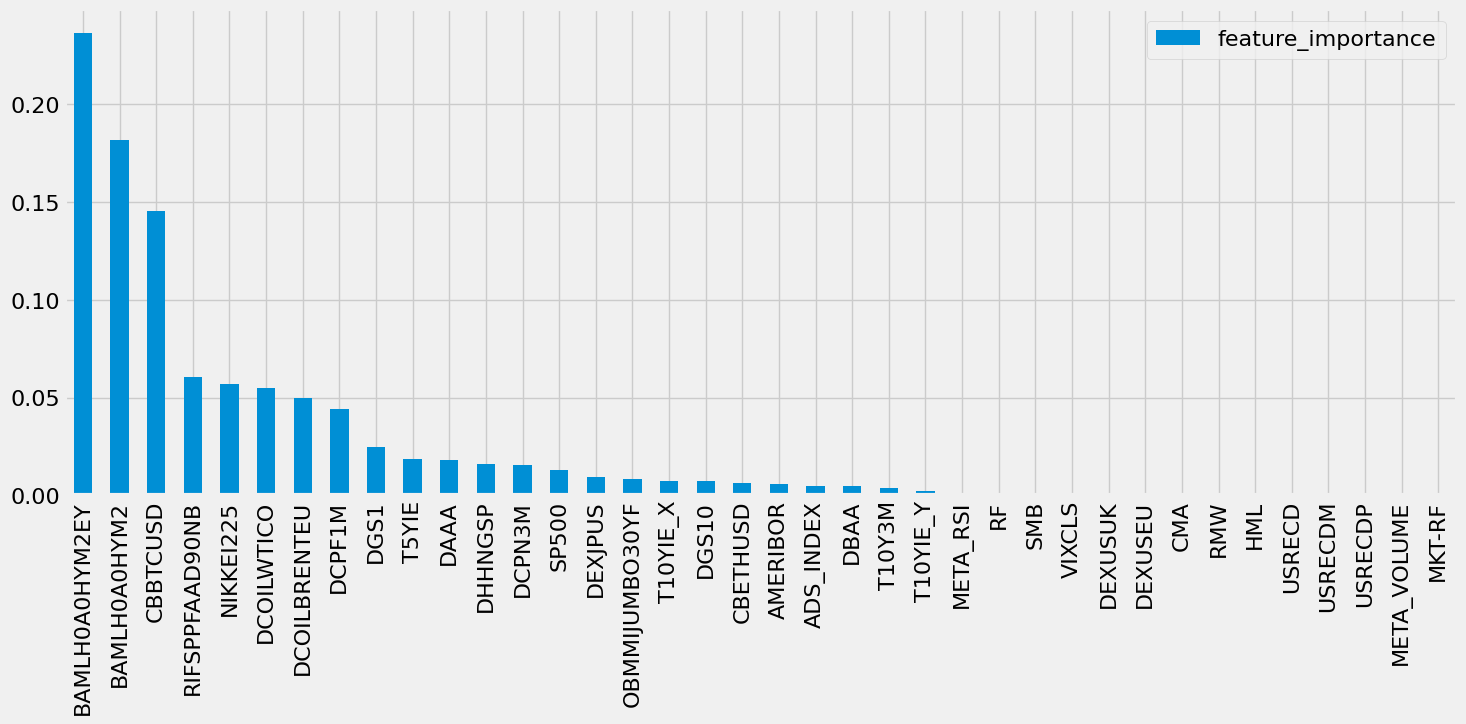

In [107]:
# 2. visualize feature importance (run each line sequentially)
# (1) bar chart
df_feature_importance.plot(kind='bar');


In [108]:
df_new_feature = df_feature_importance[df_feature_importance['feature_importance'] > 0]
df_new_feature.count()

feature_importance    26
dtype: int64

In [109]:
index_values = df_new_feature.index
print(index_values)
print(type(index_values))

Index(['BAMLH0A0HYM2EY', 'BAMLH0A0HYM2', 'CBBTCUSD', 'RIFSPPFAAD90NB',
       'NIKKEI225', 'DCOILWTICO', 'DCOILBRENTEU', 'DCPF1M', 'DGS1', 'T5YIE',
       'DAAA', 'DHHNGSP', 'DCPN3M', 'SP500', 'DEXJPUS', 'OBMMIJUMBO30YF',
       'T10YIE_X', 'DGS10', 'CBETHUSD', 'AMERIBOR', 'ADS_INDEX', 'DBAA',
       'T10Y3M', 'T10YIE_Y', 'META_RSI', 'RF'],
      dtype='object')
<class 'pandas.core.indexes.base.Index'>


In [110]:
#=========================================================================
# exhaustively search for the optimal hyperparameters
#=========================================================================
from sklearn.model_selection import GridSearchCV
# set up our search grid
param_grid = {"max_depth":    [3, 5, 10],
              "n_estimators": [10, 50, 150],
              "learning_rate": [0.15, 0.3, 0.5]}

# try out every combination of the above values
regressor = xgb.XGBRegressor(eval_metric='rmse')
search = GridSearchCV(regressor, param_grid, cv=5).fit(X, y)

print("The best hyperparameters are ",search.best_params_)
regressor = xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],)

regressor.fit(X, y)

The best hyperparameters are  {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 150}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

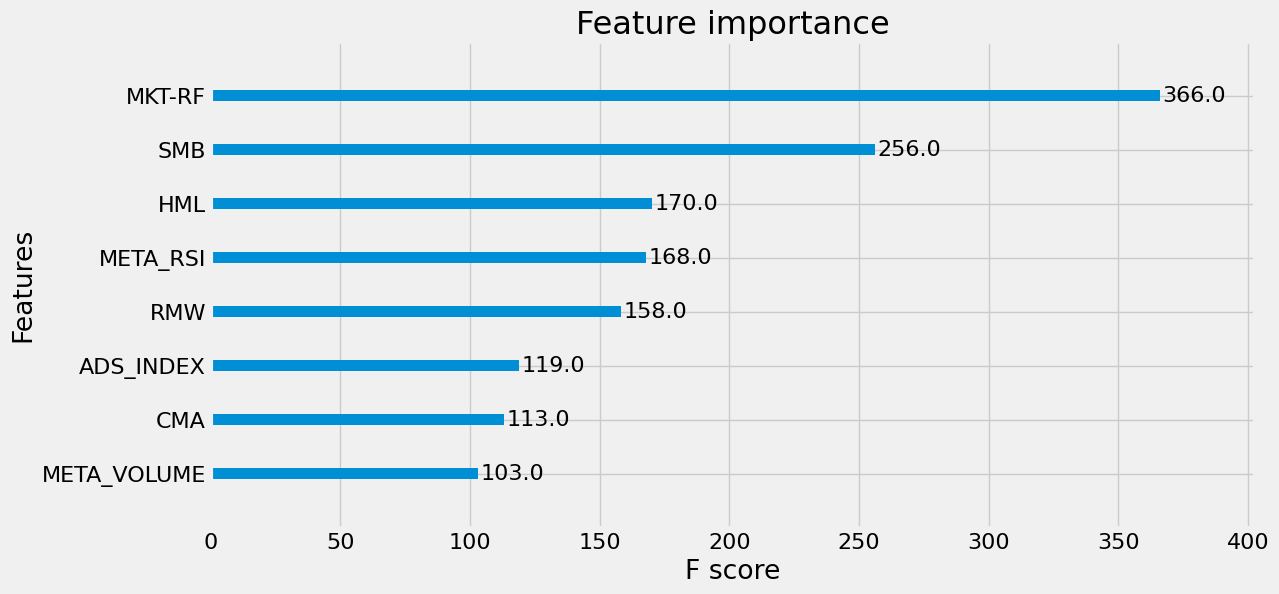

In [111]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(regressor, max_num_features=8, ax=ax)
plt.show();

In [112]:
X.columns

Index(['MKT-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'ADS_INDEX', 'SP500',
       'T10Y3M', 'OBMMIJUMBO30YF', 'DEXUSEU', 'DEXJPUS', 'DEXUSUK', 'CBBTCUSD',
       'CBETHUSD', 'T10YIE_X', 'DCOILBRENTEU', 'VIXCLS', 'DAAA', 'DBAA',
       'NIKKEI225', 'AMERIBOR', 'T10YIE_Y', 'T5YIE', 'BAMLH0A0HYM2',
       'BAMLH0A0HYM2EY', 'DGS10', 'DGS1', 'RIFSPPFAAD90NB', 'DCPN3M', 'DCPF1M',
       'DCOILWTICO', 'DHHNGSP', 'USRECD', 'USRECDM', 'USRECDP', 'META_VOLUME',
       'META_RSI'],
      dtype='object')

In [113]:
# List of columns to keep
columns_to_keep = index_values

# Drop columns except 'A' and 'B'
X = X[columns_to_keep]

In [114]:
X[:-22]

,BAMLH0A0HYM2EY,BAMLH0A0HYM2,CBBTCUSD,RIFSPPFAAD90NB,NIKKEI225,DCOILWTICO,DCOILBRENTEU,DCPF1M,DGS1,T5YIE,...,T10YIE_X,DGS10,CBETHUSD,AMERIBOR,ADS_INDEX,DBAA,T10Y3M,T10YIE_Y,META_RSI,RF
0,-1.106978,-0.081729,-0.193668,-0.894298,-0.762575,-2.227652,-2.151731,-1.096554,-1.109922,-1.716704,...,-2.092564,-1.582598,-1.293704,-0.947006,1.247945,-1.391727,0.334997,-2.092564,-0.653267,-0.843759
1,-1.101952,-0.096540,-0.037736,-0.884856,-0.815395,-2.071956,-1.978078,-1.091732,-1.109922,-1.625479,...,-1.984544,-1.555745,-1.224901,-0.940566,1.276251,-1.330460,0.358156,-1.984544,-0.457209,-0.843759
2,-1.127082,-0.274268,0.183922,-0.894298,-0.869772,-2.026797,-1.938243,-1.091732,-1.105326,-1.534255,...,-1.822513,-1.484137,-1.103084,-0.942348,1.302391,-1.225430,0.419914,-1.822513,-1.013586,-0.843759
3,-1.127082,-0.303889,0.385737,-0.889577,-0.639856,-2.014665,-1.944467,-1.091732,-1.105326,-1.382214,...,-1.660483,-1.448333,-1.089098,-0.940536,1.326380,-1.225430,0.450793,-1.660483,-0.515077,-0.843759
4,-1.132108,-0.333510,0.470812,-0.894298,-0.296245,-1.912890,-1.831811,-1.091732,-1.109922,-1.443031,...,-1.822513,-1.403578,-1.098076,-0.940289,1.348221,-1.216678,0.497112,-1.822513,-0.599809,-0.843759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,1.064256,-0.022486,-0.647354,1.631469,2.107601,0.617333,0.564482,1.463811,1.348933,-0.895685,...,-0.148203,1.657676,-0.686990,1.484704,-0.534078,1.391554,-1.108601,-0.148203,-0.101370,1.356813
686,1.104465,0.081188,-0.654881,1.631469,1.915080,0.735284,0.592490,1.420415,1.348933,-1.047725,...,-0.364243,1.666627,-0.681847,1.482115,-0.573840,1.417811,-1.100881,-0.364243,-0.231495,1.356813
687,1.129595,0.066378,-0.643077,1.655074,1.945183,0.886262,0.756808,1.420415,1.367317,-0.956501,...,-0.310233,1.711382,-0.676771,1.474914,-0.614556,1.461574,-1.062282,-0.310233,-0.317939,1.356813
688,1.124569,0.155241,-0.589853,1.617305,1.680747,0.750112,0.728177,1.454167,1.353529,-0.834868,...,-0.040183,1.693480,-0.613471,1.469539,-0.656242,1.470326,-1.062282,-0.040183,0.127151,1.356813


In [115]:
#=========================================================================
# To use early_stopping_rounds: 
# "Validation metric needs to improve at least once in every 
# early_stopping_rounds round(s) to continue training."
#=========================================================================
# first perform a test/train split 
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state=42 ,shuffle=True)
regressor.fit(X_train, y_train, early_stopping_rounds=6, eval_set=[(X_test, y_test)], verbose=False)

#=========================================================================
# use the model to predict the prices for the test data
#=========================================================================
y_hat = regressor.predict(X_test)


/home/hunter/.local/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [116]:
y_test

506    130.020004
394    160.720001
210    328.079987
247    346.179993
437    141.610001
          ...    
289    210.479996
41     257.640015
108    330.250000
513    133.020004
56     278.739990
Name: META_ADJ CLOSE, Length: 143, dtype: float64

In [117]:
###############################################################################
# Cross Validation:
# Perform cross-validation
cv_scores = cross_val_score(regressor, X, y, cv=5, scoring='neg_mean_squared_error')

# Let's get the mean score
mean_cv_score = np.mean(cv_scores)

# Get feature importances
feature_importances = model.feature_importances_

# Print the results
print("Mean Cross-Validation Score:", mean_cv_score)
print("Feature Importances:", feature_importances)

# Evaluate Model:
# Calculate the mean squared error and convert it back to positive
mse_scores = -cv_scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

rmse = np.mean(np.sqrt(np.abs(cv_scores)))
std_rmse = np.std(np.sqrt(np.abs(cv_scores)))
print('---------------------------------------','\n')
print(f'MEAN of Mean Squared Error: {mean_mse}')
print('---------------------------------------','\n')
print(f'STD of RMSE Squared Error: {std_rmse}')
print('---------------------------------------','\n')
print(f'Root Mean Squared Error on Test Set: {rmse}')
print('---------------------------------------','\n')

Mean Cross-Validation Score: -2732.812731777144
Feature Importances: [0.         0.         0.         0.         0.         0.00082368
 0.00470182 0.01290389 0.00363885 0.00842499 0.         0.00950398
 0.         0.14551374 0.00654319 0.00749926 0.04989299 0.
 0.01803155 0.00463929 0.05697815 0.00596962 0.00241818 0.01886123
 0.18190229 0.23678012 0.0072563  0.02493429 0.06079732 0.0153808
 0.04444106 0.05475182 0.01609278 0.         0.         0.
 0.         0.00131886]
--------------------------------------- 

MEAN of Mean Squared Error: 2732.812731777144
--------------------------------------- 

STD of RMSE Squared Error: 18.329714762784555
--------------------------------------- 

Root Mean Squared Error on Test Set: 48.95747428628342
--------------------------------------- 



## There is no overfitting given the STD of RMSE is smaller than RMSE

In [118]:
## There is no overfitting given the STD of RMSE is smaller than RMSE

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_hat)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(rmse)

7.845593839739905


## Trading Rules

In [119]:
### Creating input data for month of October 2023
new_X = X[-22:]
new_y_test = y[-22:]

In [120]:
### Predicting using XGBoost
y_pred = regressor.predict(new_X)

In [121]:
import numpy as np

def TRADING_RULE(P_hat, P, options):
    if options == 'BUY HOLD':
        return TRADING_RULE_1(P)
    elif options == 'LONG SHORT':
        return TRADING_RULE_2(P_hat, P)
    elif options == 'DAY TRADE':
        return TRADING_RULE_3(P_hat, P)

def TRADING_RULE_1(P):
    T = P.shape[0]
    signal = np.zeros(T)
    signal[0] = 1
    signal[-1] = -1
    return signal

def TRADING_RULE_2(P_hat, P):
    T = P.shape[0]
    signal = np.zeros(T)
    for t in range(1, T):
        if (P_hat[t-1] > P[t-1]) + (P_hat[t] < P[t]) == 2:  # FORCAST > OPEN: LONG
            signal[t] = 1
        elif (P_hat[t-1] < P[t-1]) + (P_hat[t] > P[t]) == 2:  # FORECAST < OPEN: SHORT
            signal[t] = -1
    return signal

def TRADING_RULE_3(P_hat, P):
    T = P.shape[0]
    signal = np.zeros(T)
    for t in range(1, T):
        if P_hat[t] > P[t]:  # FORCAST > OPEN: LONG
            signal[t] = 1
        elif P_hat[t] < P[t]:  # FORECAST < OPEN: SHORT
            signal[t] = -1
    return signal

In [122]:
import numpy as np

def calculate_profit_loss(signal, price):
    T = len(signal)
    position = np.zeros(T)
    balance = np.zeros(T)
    position[1:] = np.diff(signal)  # Buy (1) or Sell (-1) at each signal change
    balance[0] = 10000  # Initial balance
    for t in range(1, T):
        balance[t] = balance[t - 1] + position[t] * price[t]
    return balance

# Example usage:
# Assume 'price' is a numpy array or list containing the asset prices over time
# and 'signal' is the trading signal generated by TRADING_RULE function.

# Example price data
price = new_y_test.values

# Example trading signal
signal = TRADING_RULE(y_pred, new_y_test.values, 'DAY TRADE')

# Calculate profit and loss
profit_loss = calculate_profit_loss(signal, price)

# Display the results
print("Trading Signal:", signal)
print("Asset Prices:", price)
print("Profit and Loss:", profit_loss)

Trading Signal: [ 0. -1.  1.  1.  1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1. -1.
 -1.  1. -1.  1.]
Asset Prices: [306.8200073 300.9400024 305.5799866 304.7900085 315.4299927 318.3599854
 321.8399963 327.8200073 324.1600037 314.6900024 321.1499939 324.
 316.9700012 312.8099976 308.6499939 314.0100098 312.5499878 299.5299988
 288.3500061 296.730011  302.6600037 301.269989 ]
Profit and Loss: [10000.         9699.0599976 10310.2199708 10310.2199708 10310.2199708
  9673.5       10317.1799926  9661.539978   9661.539978   9661.539978
  9661.539978  10309.539978  10309.539978  10309.539978   9692.2399902
  9692.2399902 10317.3399658  9718.2799682  9718.2799682 10311.7399902
  9706.4199828 10308.9599608]


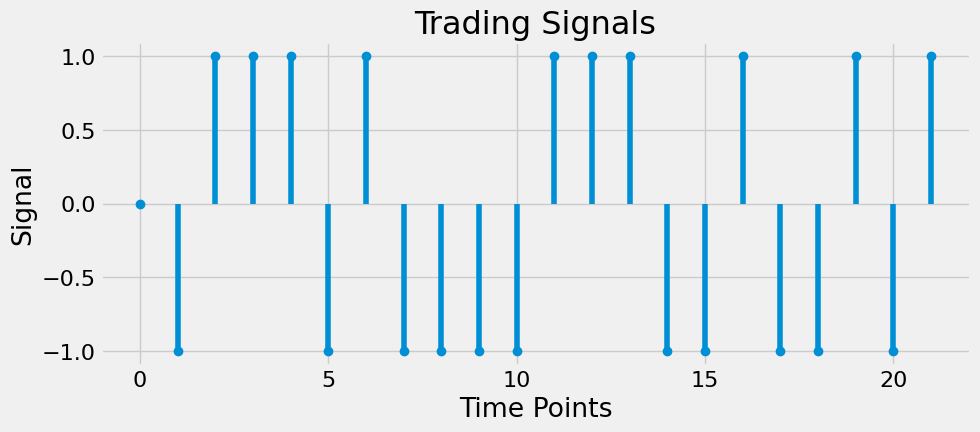

In [123]:
import matplotlib.pyplot as plt
import numpy as np


trading_signals = signal

time_points = np.arange(len(trading_signals))

# Plot the trading signals
plt.figure(figsize=(10, 4))
plt.stem(time_points, trading_signals, basefmt=" ", markerfmt="o", linefmt="-")
plt.title('Trading Signals')
plt.xlabel('Time Points')
plt.ylabel('Signal')
plt.show()

In [124]:
Total_Profit = profit_loss[-1] - profit_loss[0]
print(str(np.round(Total_Profit)) + ' USD')

309.0 USD


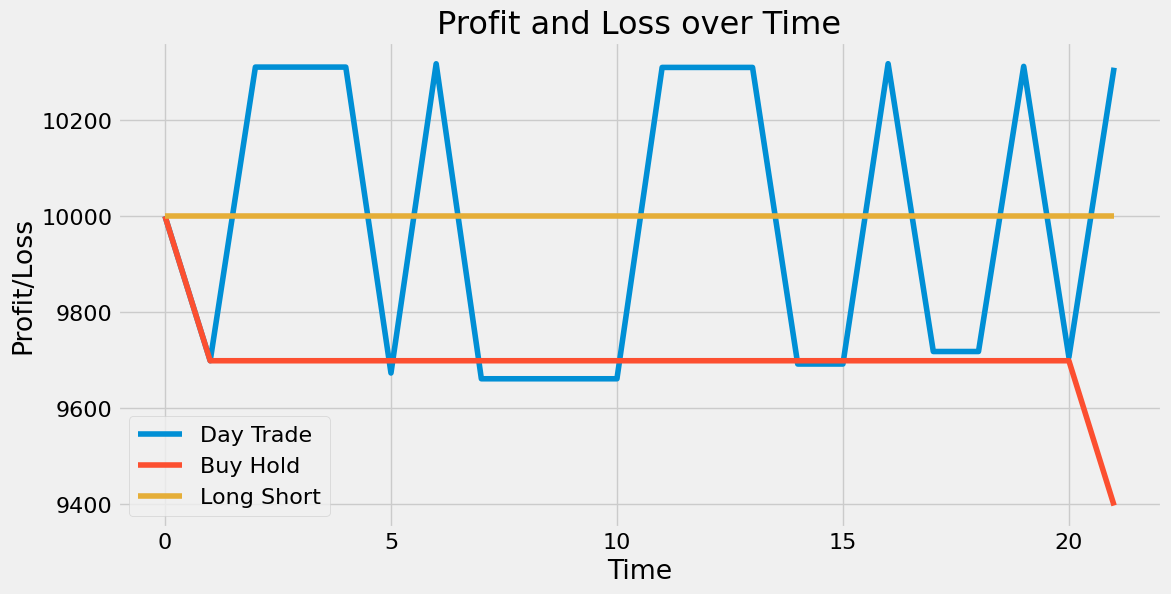

In [125]:
# Example trading signals
signal1 = TRADING_RULE(y_pred, new_y_test.values, 'DAY TRADE')
signal2 = TRADING_RULE(y_pred, new_y_test.values, 'BUY HOLD')
signal3 = TRADING_RULE(y_pred, new_y_test.values, 'LONG SHORT')

# Calculate profit and loss for each signal
profit_loss1 = calculate_profit_loss(signal1, price)
profit_loss2 = calculate_profit_loss(signal2, price)
profit_loss3 = calculate_profit_loss(signal3, price)

# Plotting the results
plt.figure(figsize=(12, 6))

plt.plot(profit_loss1, label='Day Trade')
plt.plot(profit_loss2, label='Buy Hold')
plt.plot(profit_loss3, label='Long Short')

plt.title('Profit and Loss over Time')
plt.xlabel('Time')
plt.ylabel('Profit/Loss')
plt.legend()

plt.show()